In [1]:
import glob
import random 

import matplotlib.patches as patches

from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from matplotlib.font_manager import FontProperties

from imports import *
from custom_dataset import SimpsonsDataset

In [2]:
def set_parameter_requires_grad(model, feature_extracting = False):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [3]:
model = None
num_classes = 42 #в simpson_dataset всего 42 класса, замените на своё значение
model = models.resnet50()
set_parameter_requires_grad(model)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [4]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
test_files = sorted(Path(test_dir).rglob('*.jpg'))
test_dataset = SimpsonsDataset(test_files, mode="test")

In [6]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
def predict_one_sample(model, img_tensor):
    with torch.no_grad():
        img_tensor = img_tensor.cpu()
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

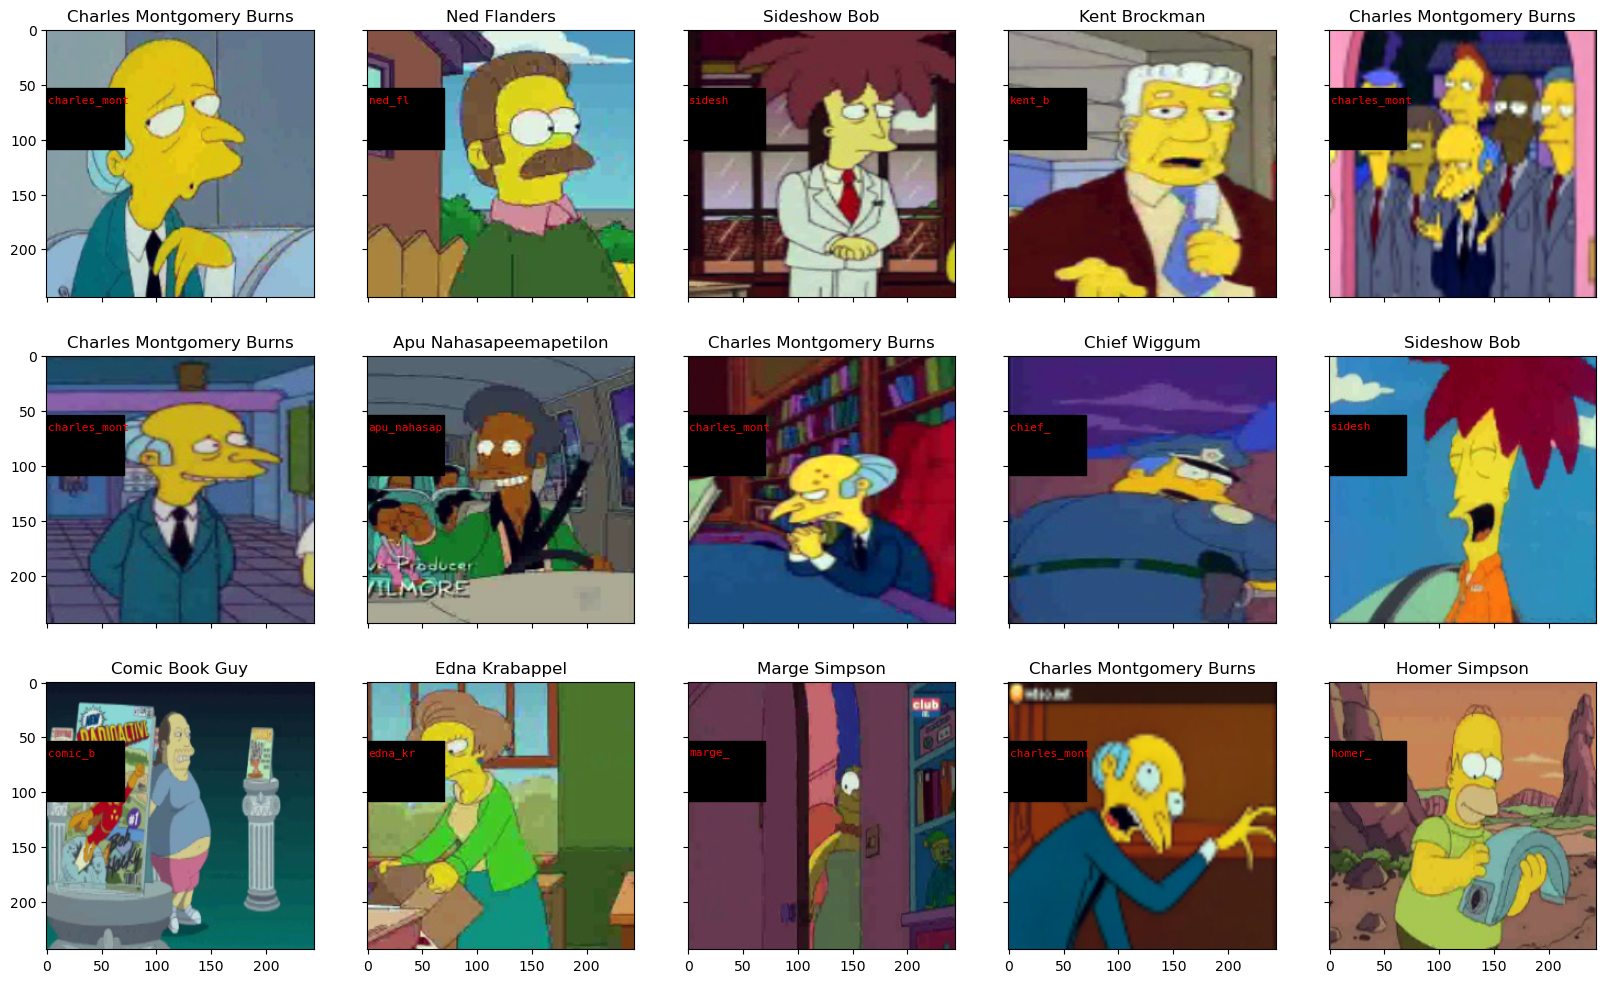

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(test_dataset)))
    im_test, label = test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),test_dataset.l_e.inverse_transform([label])[0].split('_')))

    imshow(im_test.data.cpu(),title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

   
    prob_pred = predict_one_sample(model, im_test.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2]
    predicted_text = "{}".format(predicted_label)
    
    fig_x.add_patch(patches.Rectangle((0, 53), 70, 55, color='black'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    
    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font, verticalalignment='top', fontsize=8, color='red',)